In [1]:
# hide_input
# ▶️ Run this cell to load sample images & SPCNN base model.
print("▶️ Loading sample images & SPCNN model…")

import sys, os
from pathlib import Path

# 1) Make sure repo root is on PYTHONPATH
repo_root = Path(os.getcwd()).parent
sys.path.insert(0, str(repo_root))

# 2) Config paths
DATA_PATH    = repo_root / "notebooks" / "sample_data"
WEIGHTS_PATH = repo_root / "notebooks" / "src" / "model.pth"

# 3) Model & device
import torch
from models.model_factory import get_model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cfg = {"name": "spcnn", "num_classes": 2}
model = get_model(model_cfg).to(DEVICE).eval()

# 4) Load & remap checkpoint
checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
state_dict = checkpoint.get("state_dict", checkpoint)
mapped = {
    (k.replace("features.", "feature_extractor.") if k.startswith("features.") else k): v
    for k, v in state_dict.items()
}
model.load_state_dict(mapped, strict=False)

# 5) Sample images & preprocessing pipeline
import numpy as np
from PIL import Image
from data.transforms import get_preprocessing_pipeline

IMAGE_SIZE = 224
preprocess = get_preprocessing_pipeline(
    resize=(IMAGE_SIZE, IMAGE_SIZE),
    apply_clahe=True,
    apply_dilation=True
)

img_paths = sorted(DATA_PATH.glob("*.png"))

def load_and_preprocess(p: Path):
    arr = np.array(Image.open(p).convert("RGB"))
    tensor = torch.from_numpy(preprocess(image=arr)["image"]).unsqueeze(0)
    return tensor.to(DEVICE)

print(f"✅ Loaded {len(img_paths)} sample images and SPCNN model on {DEVICE}")


▶️ Loading sample images & SPCNN model…
✅ Loaded 10 sample images and SPCNN model on cpu


c:\Users\Caterina\anaconda3\envs\xai4malaria-demo\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] No se encontró el proceso especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# hide_input
# ▶️ Run this cell to hook Grad-CAM to the same target layer as in your scripts.

import torch, yaml
from explainability.gradcam import GradCAM

# 1) Helper to resolve a “dotted” layer path into the actual module
def resolve_target_module(model, layer_str):
    parts  = layer_str.split(".")
    module = model
    for p in parts:
        module = module[int(p)] if p.isdigit() else getattr(module, p)
    return module

# 2) Load your XAI config to get the exact layer string
GRADCAM_YAML = repo_root / "configs" / "xai_gradcam.yaml"
cfg = yaml.safe_load(open(GRADCAM_YAML, "r"))
layer_str = cfg["xai"]["target_layer"]  # e.g. "feature_extractor.4", check your YAML

# 3) Resolve and instantiate GradCAM
target_module = resolve_target_module(model, layer_str)
explainer     = GradCAM(model, target_module, device=DEVICE)

print(f"✅ GradCAM hooked to layer: {layer_str}")


✅ GradCAM hooked to layer: feature_extractor.1.3.block.0


In [3]:
import numpy as np
import cv2

def overlay_cam(orig_rgb: np.ndarray,
                cam: np.ndarray,
                alpha: float = 0.4,
                colormap=cv2.COLORMAP_JET):
    H, W = orig_rgb.shape[:2]
    orig_bgr = cv2.cvtColor(orig_rgb, cv2.COLOR_RGB2BGR)

    p_low, p_high = np.percentile(cam, [5, 99])
    cam_clipped   = np.clip(cam, p_low, p_high)
    cam_norm      = (cam_clipped - cam_clipped.min()) / (p_high - cam_clipped.min() + 1e-8)

    heat_u8  = (cam_norm * 255).astype(np.uint8)
    heat_bgr = cv2.applyColorMap(heat_u8, colormap)
    heat_bgr = cv2.resize(heat_bgr, (W, H), interpolation=cv2.INTER_LINEAR)

    blended = cv2.addWeighted(orig_bgr, 1 - alpha, heat_bgr, alpha, 0)
    mask    = np.any(orig_bgr != 0, axis=2)[:, :, None]
    result  = np.where(mask, blended, orig_bgr)

    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)


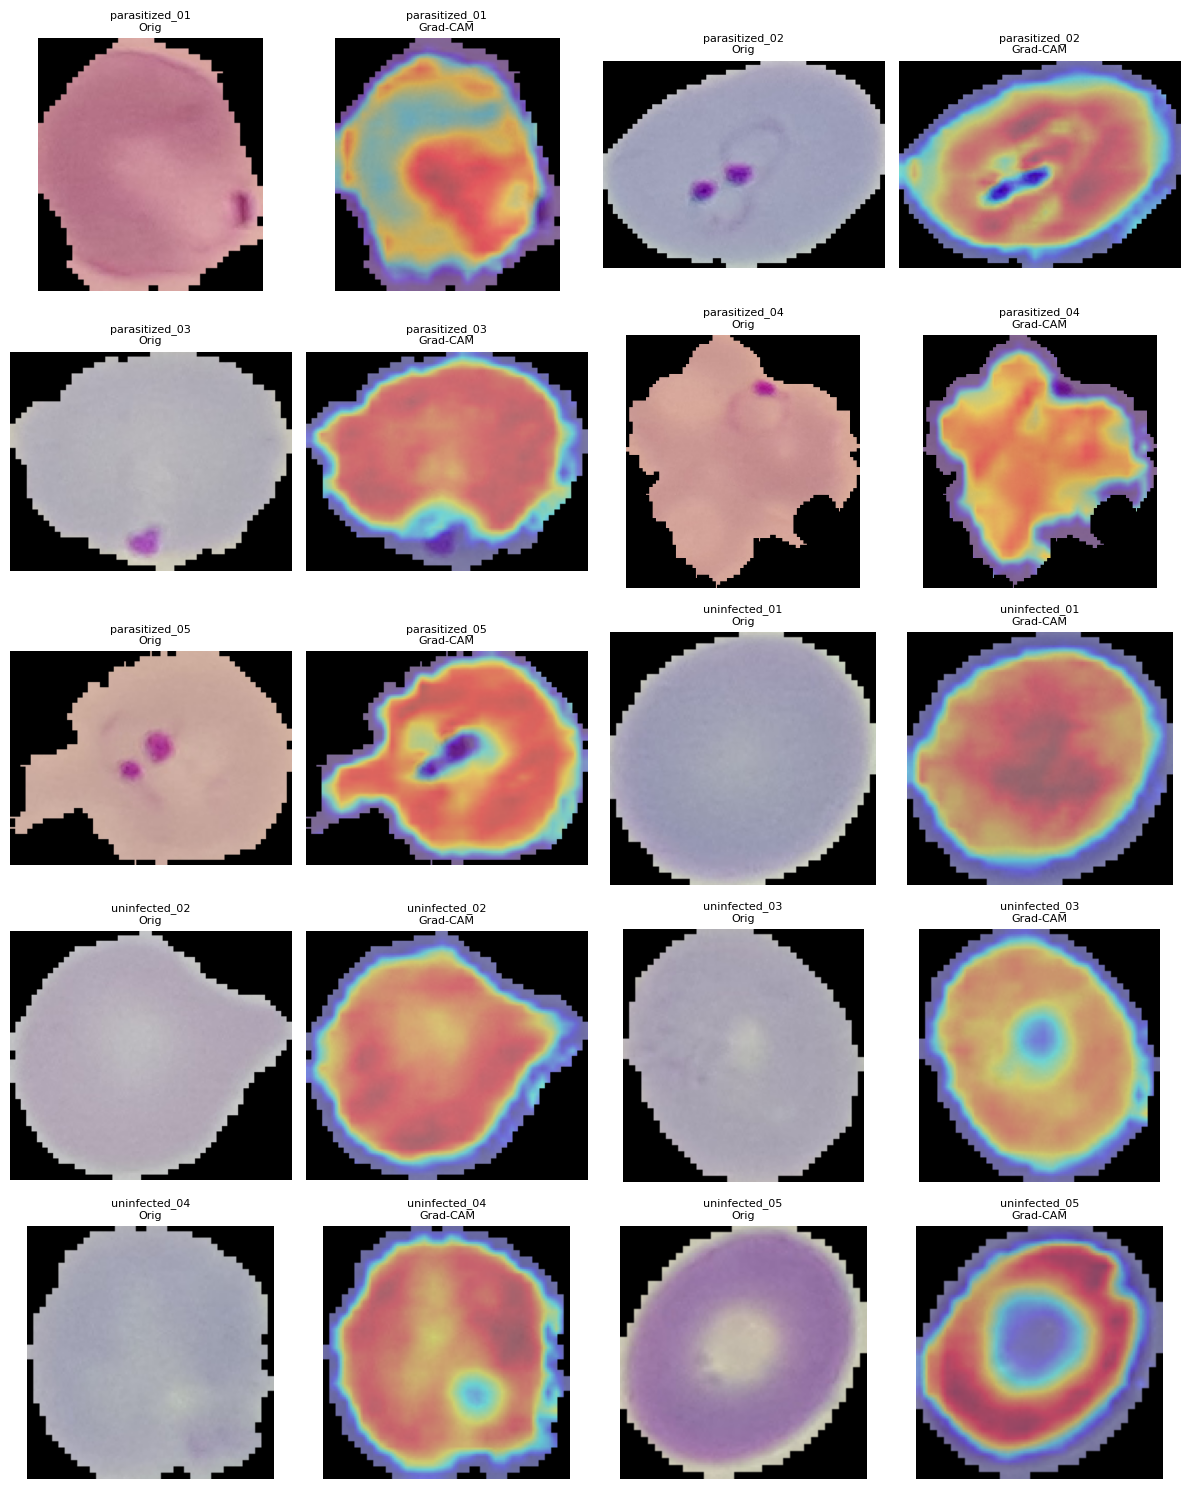

In [4]:
# hiden_input
# ▶️ Run this cell to create a function to xx

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from pathlib import Path

# 1) Torchvision‐style loader (no keyword args)
def tv_loader(p: Path):
    img = Image.open(p).convert("RGB")
    return preprocess(img).unsqueeze(0).to(DEVICE)

# 2) Prepare grid
n_rows, n_cols = 5, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)

# blank all axes
for row in axes:
    for ax in row:
        ax.axis('off')

# 3) Fill each row: orig & Grad-CAM for two samples per row
for idx, p in enumerate(img_paths):
    row = idx // 2
    pair_idx = idx % 2
    c_orig = pair_idx * 2
    c_cam  = c_orig + 1

    # preprocess & predict
    x    = tv_loader(p)
    pred = model(x).argmax(dim=1).item()

    # generate & resize CAM
    cam = explainer.generate_heatmap(x, class_idx=pred)          # H×W numpy
    orig_arr = np.array(Image.open(p).convert("RGB"))
    h, w = orig_arr.shape[:2]
    cam_r = cv2.resize(cam, (w, h), interpolation=cv2.INTER_LINEAR)

    # plot original
    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title(f"{p.stem}\nOrig", fontsize=8)
    axes[row, c_orig].axis('off')

    # plot overlay
    ov = overlay_cam(orig_arr, cam, alpha=0.4)
    axes[row, c_cam].imshow(ov)
    axes[row, c_cam].set_title(f"{p.stem}\nGrad-CAM", fontsize=8)
    axes[row, c_cam].axis('off')

plt.tight_layout()
plt.show()


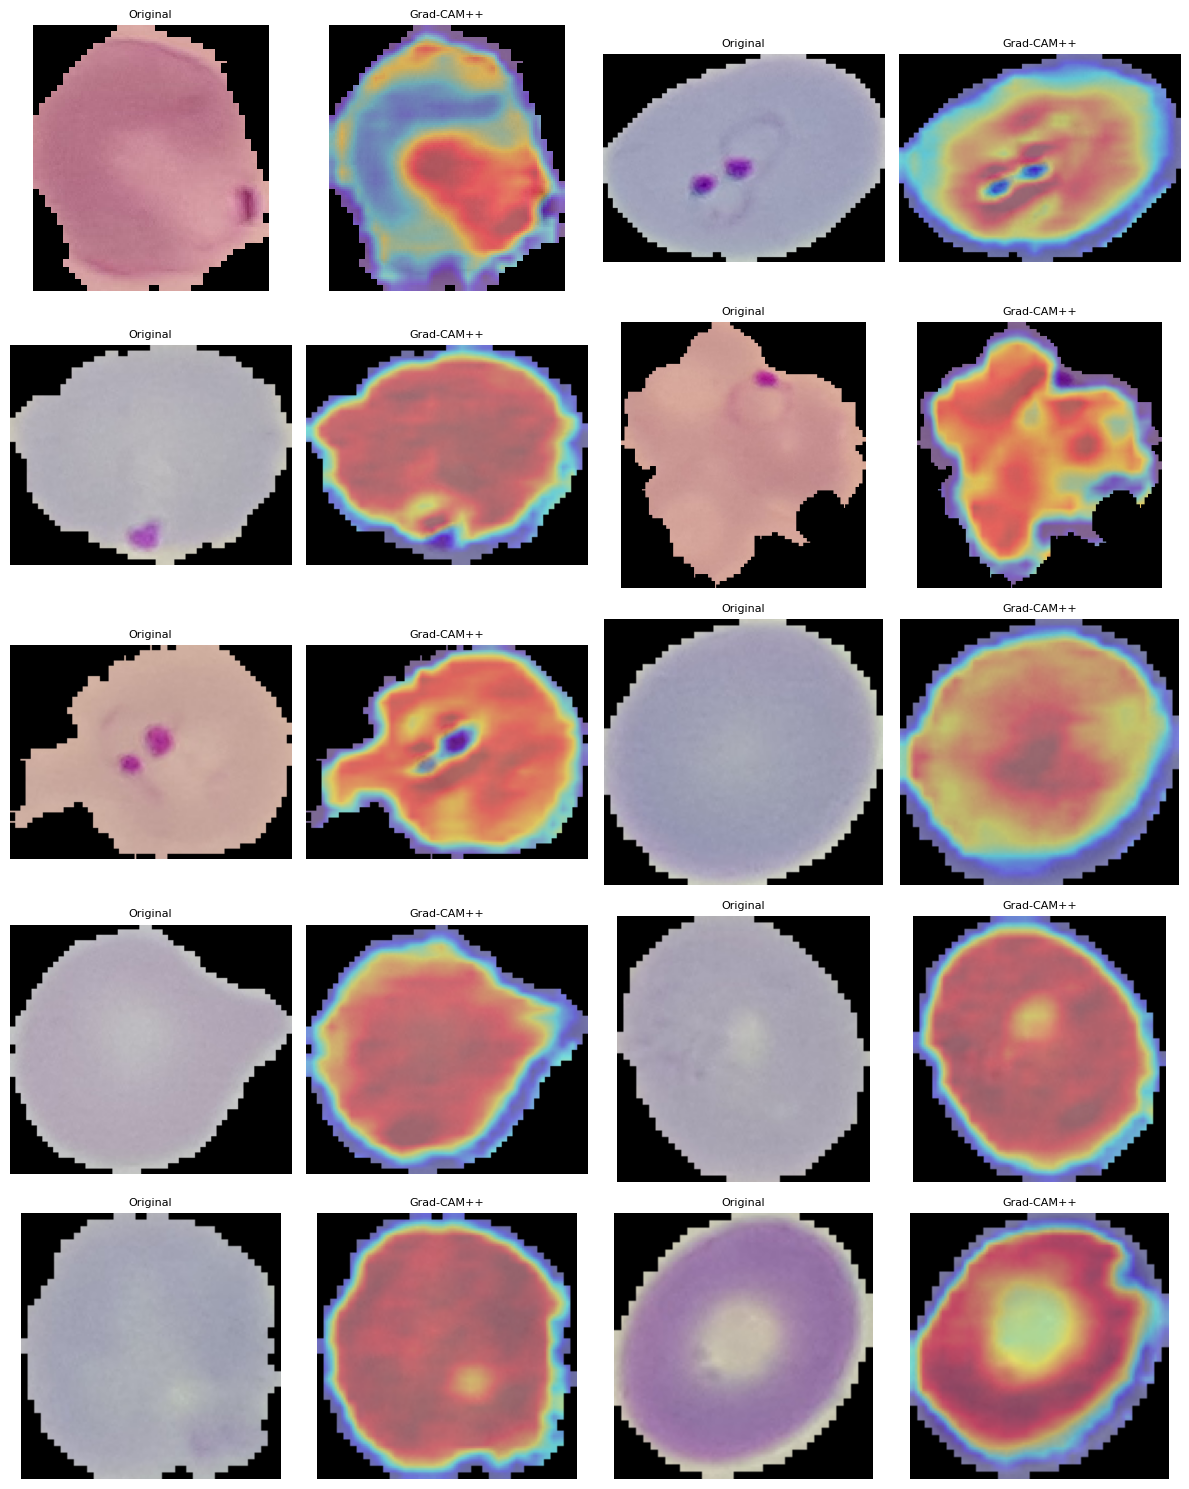

In [5]:
# ▶️ Run this cell to display Grad-CAM++ overlays in a 5×4 grid

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from explainability.gradcam_plus_plus import GradCAMPlusPlus

# instantiate Grad-CAM++
explainer_pp = GradCAMPlusPlus(model, target_module)

# prepare the grid
n_rows, n_cols = 5, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)
for row in axes:
    for ax in row:
        ax.axis('off')

# loop over sample images
for idx, p in enumerate(img_paths):
    row      = idx // 2
    pair_idx = idx % 2
    c_orig   = pair_idx * 2
    c_cam    = c_orig + 1

    # load & predict
    x    = tv_loader(p)
    pred = model(x).argmax(dim=1).item()

    # generate CAM and resize it
    cam_tensor = explainer_pp(x, class_idx=pred)
    cam        = cam_tensor[0].detach().cpu().numpy()
    orig_arr   = np.array(Image.open(p).convert("RGB"))
    h, w       = orig_arr.shape[:2]
    cam_r      = cv2.resize(cam, (w, h), interpolation=cv2.INTER_LINEAR)

    # plot original
    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title("Original", fontsize=8)

    # plot overlay
    ov = overlay_cam(orig_arr, cam, alpha=0.4)
    axes[row, c_cam].imshow(ov)
    axes[row, c_cam].set_title("Grad-CAM++", fontsize=8)

plt.tight_layout()
plt.show()


In [6]:
# hide_input
# ▶️ Run this cell to set up SHAP Deep & Gradient Explainers on four samples
import warnings
warnings.filterwarnings("ignore", message="unrecognized nn.Module")
from explainability.shap import SHAPExplainer
from scipy.ndimage import gaussian_filter

# pick two parasitized and two uninfected samples
pos_paths = [p for p in img_paths if "parasitized" in p.stem][:2]
neg_paths = [p for p in img_paths if "uninfected" in p.stem][:2]
# background built from these same four
tensors = [tv_loader(p) for p in pos_paths + neg_paths]
background = torch.cat(tensors, dim=0)

# instantiate Deep and Gradient explainers
explainer_deep = SHAPExplainer(
    model,
    background,
    device=DEVICE,
    explainer_type="deep",
    nsamples=0
)
explainer_grad = SHAPExplainer(
    model,
    background,
    device=DEVICE,
    explainer_type="gradient",
    nsamples=50
)
print("✅ SHAP explainers (Deep & Gradient) ready for four images")

✅ SHAP explainers (Deep & Gradient) ready for four images


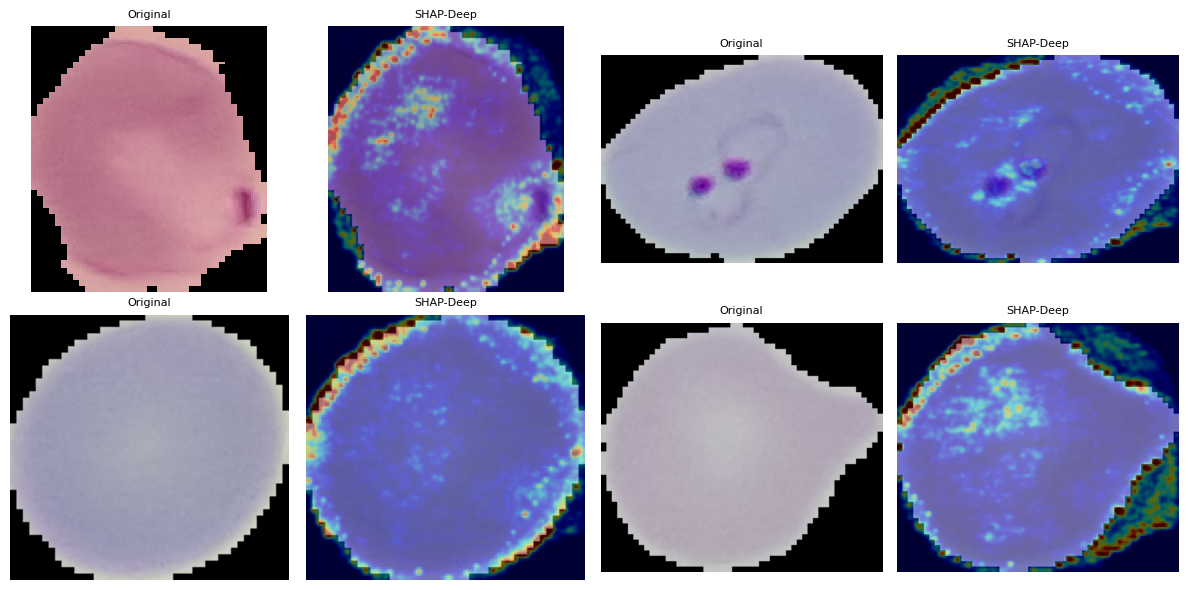

In [7]:
# ▶️ Run this cell to display SHAP-Deep overlays for four images
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

# grid: 2 rows, each with orig + SHAP pairs
test_paths = pos_paths + neg_paths
n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)
for row in axes:
    for ax in row:
        ax.axis('off')

for idx, p in enumerate(test_paths):
    row = idx // 2
    pair_idx = idx % 2
    c_orig = pair_idx * 2
    c_shap = c_orig + 1

    # load
    orig_arr = np.array(Image.open(p).convert("RGB"))
    x = tv_loader(p)
    pred = model(x).argmax(dim=1).item()

    # compute SHAP map
    shap_map = explainer_deep(x, class_idx=pred)
    # ensure channel-last attribution: shap_map shape is (1, H, W, C)
    shap_arr = shap_map[0].detach().cpu().numpy()
    # extract attribution for predicted class channel
    cam_raw = np.abs(shap_arr[:, :, pred])
    cam_smooth = gaussian_filter(cam_raw, sigma=1.5)

    # normalize like save_cam
    p_low, p_high = np.percentile(cam_smooth, [5, 99])
    cam_clipped = np.clip(cam_smooth, p_low, p_high)
    cam_norm = (cam_clipped - p_low) / (p_high - p_low + 1e-8)

    h, w = orig_arr.shape[:2]
    heat_bgr = cv2.applyColorMap((cam_norm*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat_bgr = cv2.resize(heat_bgr, (w, h), interpolation=cv2.INTER_LINEAR)
    orig_bgr = cv2.cvtColor(orig_arr, cv2.COLOR_RGB2BGR)
    over_bgr = cv2.addWeighted(orig_bgr, 0.6, heat_bgr, 0.4, 0)
    ov = cv2.cvtColor(over_bgr, cv2.COLOR_BGR2RGB)

    # plot
    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title("Original", fontsize=8)
    axes[row, c_shap].imshow(ov)
    axes[row, c_shap].set_title("SHAP-Deep", fontsize=8)

plt.tight_layout()
plt.show()

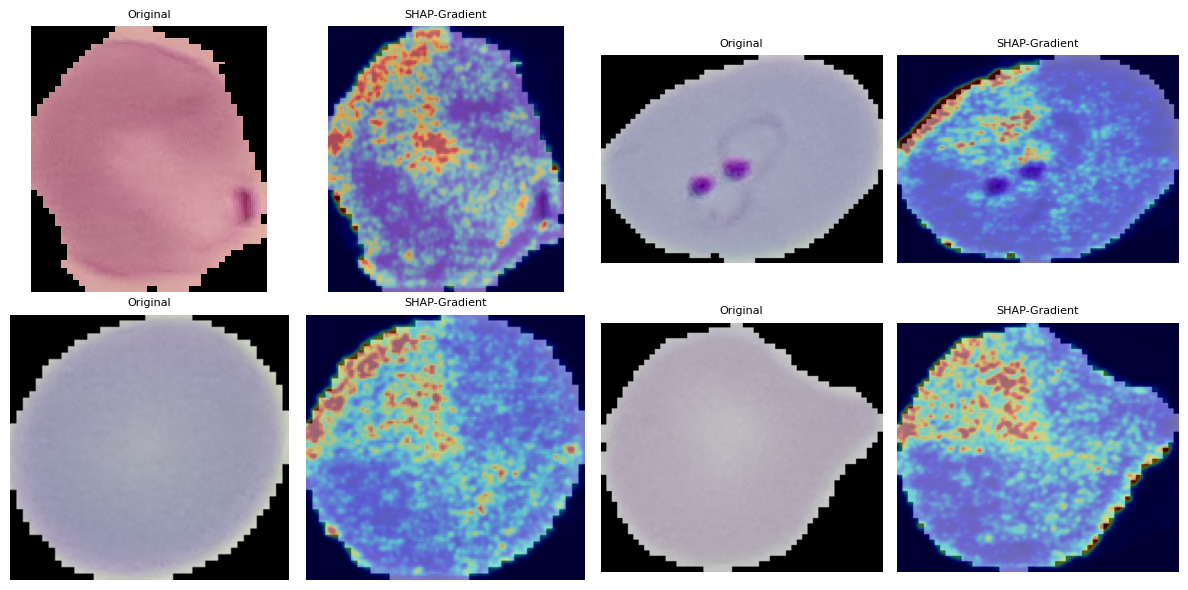

In [8]:
# ▶️ Run this cell to display SHAP-Gradient overlays for four images
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)
for row in axes:
    for ax in row: ax.axis('off')

for idx, p in enumerate(test_paths):
    row = idx // 2
    pair_idx = idx % 2
    c_orig, c_shap = pair_idx*2, pair_idx*2+1

    orig_arr = np.array(Image.open(p).convert("RGB"))
    x = tv_loader(p)
    pred = model(x).argmax(dim=1).item()

    shap_map = explainer_grad(x, class_idx=pred)
    shap_arr = shap_map[0].detach().cpu().numpy()
    cam_raw = np.abs(shap_arr[:, :, pred])
    cam_smooth = gaussian_filter(cam_raw, sigma=1.5)

    p_low, p_high = np.percentile(cam_smooth, [5, 99])
    cam_clipped = np.clip(cam_smooth, p_low, p_high)
    cam_norm = (cam_clipped - p_low) / (p_high - p_low + 1e-8)

    H, W = orig_arr.shape[:2]
    heat_bgr = cv2.applyColorMap((cam_norm*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat_bgr = cv2.resize(heat_bgr, (W, H), interpolation=cv2.INTER_LINEAR)
    orig_bgr = cv2.cvtColor(orig_arr, cv2.COLOR_RGB2BGR)
    over_bgr = cv2.addWeighted(orig_bgr, 0.6, heat_bgr, 0.4, 0)
    ov = cv2.cvtColor(over_bgr, cv2.COLOR_BGR2RGB)

    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title("Original", fontsize=8)
    axes[row, c_shap].imshow(ov)
    axes[row, c_shap].set_title("SHAP-Gradient", fontsize=8)

plt.tight_layout()
plt.show()

TypeError: Compose.__call__() got an unexpected keyword argument 'image'

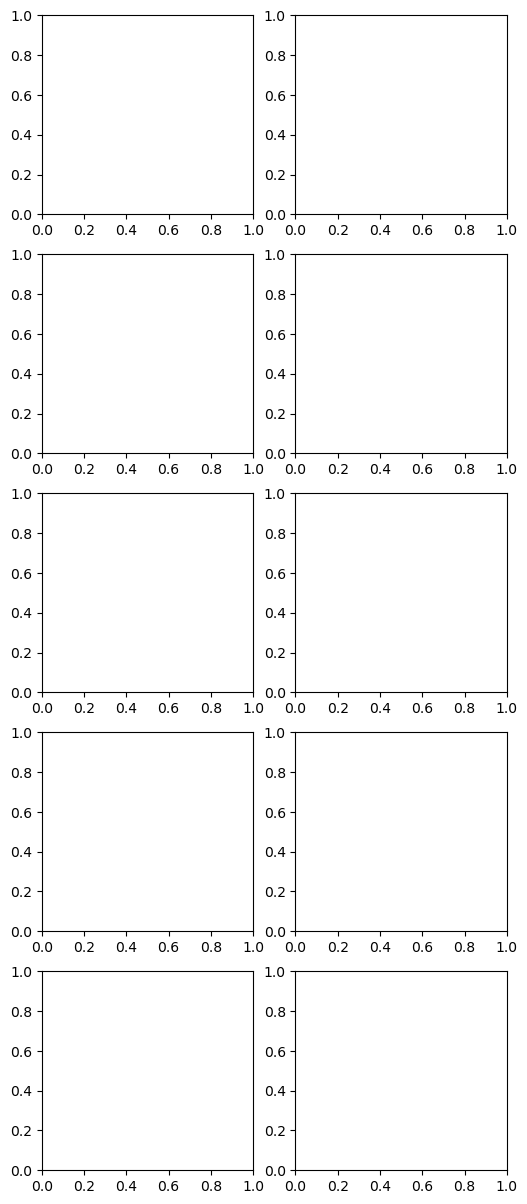

In [ ]:
# ▶️ Run this cell to generate and display LIME overlays (no saving)

from lime import lime_image
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# 1) Define prediction function for LIME (expects numpy, returns probabilities)
def predict_fn(images_np):
    images_tensor = torch.stack([
        torch.from_numpy(preprocess(image=img)["image"])
        for img in images_np
    ]).to(DEVICE)
    with torch.no_grad():
        logits = model(images_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

# 2) Instantiate LimeImageExplainer
lime_explainer = lime_image.LimeImageExplainer()

# 3) Plot explanations for the first 5 sample images
n_images = 5
fig, axes = plt.subplots(n_images, 2, figsize=(6, 3 * n_images))

for i, img_path in enumerate(img_paths[:n_images]):
    orig = Image.open(img_path).convert("RGB")
    arr = np.array(orig)

    # Predict label
    x = torch.from_numpy(preprocess(arr)).unsqueeze(0).to(DEVICE)
    pred = model(x).argmax(dim=1).item()

    # Run LIME
    explanation = lime_explainer.explain_instance(
        image=arr,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get overlay
    lime_img, mask = explanation.get_image_and_mask(
        label=pred,
        positive_only=True,
        num_features=8,
        hide_rest=False
    )

    # Plot original
    axes[i, 0].imshow(arr)
    axes[i, 0].set_title(f"{img_path.stem}\nOriginal", fontsize=8)
    axes[i, 0].axis("off")

    # Plot LIME overlay
    axes[i, 1].imshow(mark_boundaries(lime_img, mask))
    axes[i, 1].set_title(f"{img_path.stem}\nLIME", fontsize=8)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()